<a href="https://colab.research.google.com/github/obasho/obasho/blob/main/CatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels


68606236/68606236 [==============================] - 0s 0us/step
/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255,rotation_range=40,
      width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
      horizontal_flip=True,fill_mode='nearest')  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


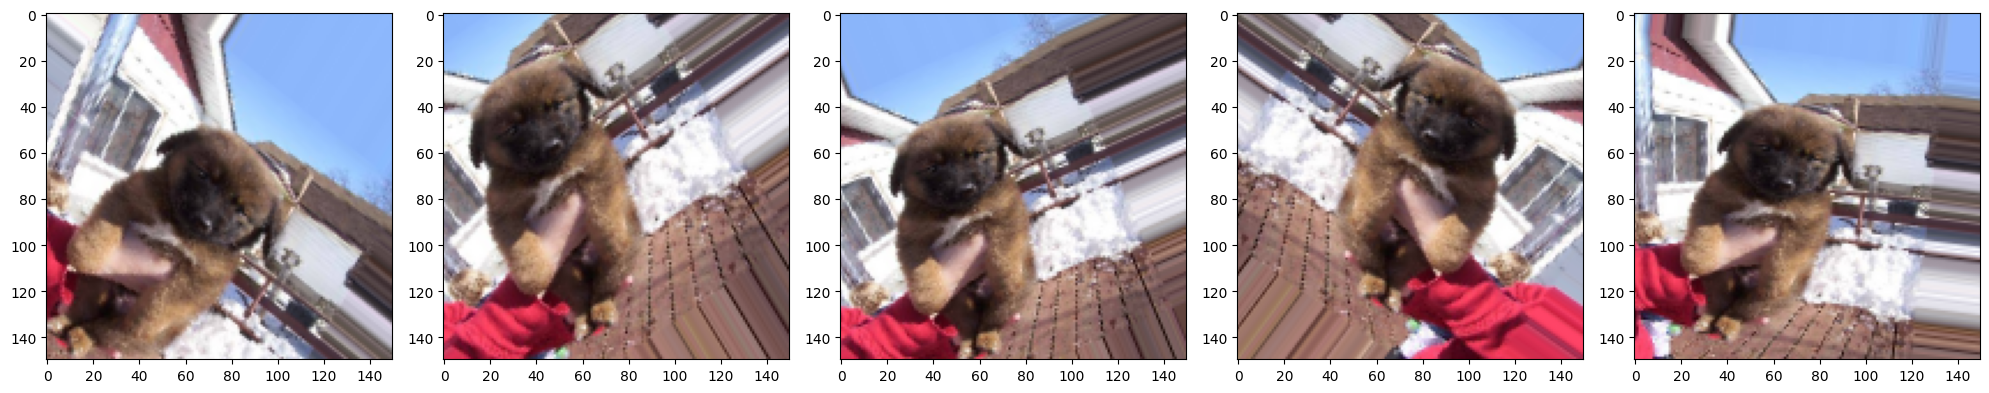

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.math.sigmoid,kernel_initializer='he_normal', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation=tf.math.sigmoid, kernel_initializer='he_normal', padding='same'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation=tf.math.sigmoid,kernel_initializer='he_normal', padding='same'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.math.sigmoid),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation=tf.math.sigmoid),
    tf.keras.layers.Dense(2,activation=tf.nn.softmax)
])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir='logs'),tf.keras.callbacks.History()]

model.compile(optimizer=tf.keras.optimizers.experimental.Adadelta(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 dropout_59 (Dropout)        (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_60 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                               

In [ ]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),callbacks=callbacks
)

Epoch 1/100
20/20 [==============================] - 17s 755ms/step - loss: 0.9037 - accuracy: 0.5000 - val_loss: 0.8510 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 14s 720ms/step - loss: 0.8080 - accuracy: 0.5000 - val_loss: 0.7810 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 16s 793ms/step - loss: 0.7516 - accuracy: 0.5000 - val_loss: 0.7418 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - 15s 752ms/step - loss: 0.7217 - accuracy: 0.5000 - val_loss: 0.7202 - val_accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 16s 789ms/step - loss: 0.7070 - accuracy: 0.4995 - val_loss: 0.7084 - val_accuracy: 0.5000
Epoch 6/100
20/20 [==============================] - 16s 794ms/step - loss: 0.7025 - accuracy: 0.4980 - val_loss: 0.7018 - val_accuracy: 0.5000
Epoch 7/100
20/20 [==============================] - 16s 792ms/step - loss: 0.6973 - accuracy: 0.5040 - val_loss: 0.6984 - val_accuracy:

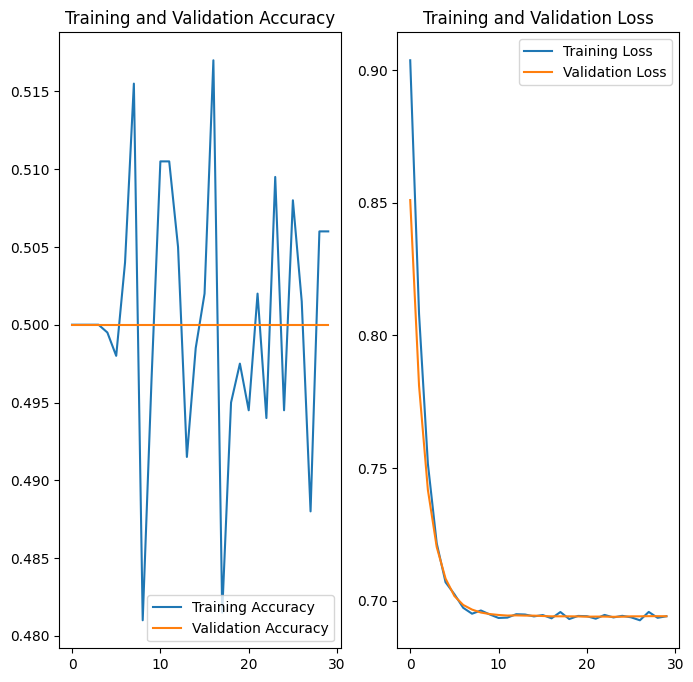

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()